<h1> pyNEST</h1> <h1> generate Nph,Ne and S1,S2 from differental energy spectrum. For LZ </h1>

In [1]:
from __future__ import division
import pylab
import scipy.interpolate as ip
import sys
sys.path.insert(2, '//global/project/projectdirs/lux/data') #frozen with NEST v98
from aLib import pyNEST as pn
from aLib import inrange
from aLib import eff
from aLib import rates
import matplotlib as mpl
import matplotlib.pyplot as plt
from numpy import *
import scipy.stats as st
import numpy as np
import scipy.io as sio
%pylab inline  
#always do this for plotting...  don't ask why
pylab.rcParams['figure.figsize'] = (10.0, 8.0) # set size of figures

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


<h1> Define function dN/dE->quanta->signal, for LZ </h1>

In [79]:
def dN2NphNe(ParticleType='ER',file_path='data/PP_7Be_evt_ton_year_keV_lin_noDiscrim.txt', total_rate=0.001, kg_days=5600*1000, f_drift=700,g1=0.075,SPE_res= 0.5,eff_extract=0.95,SE_size=50,SE_res=sqrt(50),e_lifetime=1000, dt0=500):
    #input: ParticleType('ER' or 'NR'), file path to diff spectrum, total rate in evts/kg/day, drift field V/cm, g1, SPE_res, electron extraction efficiency, SE size, sigSE, electron lifetime, center of detector)
       
    nSim=ceil(total_rate*5600*1000)
    Edata, rate=np.loadtxt(file_path,skiprows=0,unpack=True) #evts/ton/year with 1/200 discrim
    #Energy scale must be linear in text file for code to work properly!
    dR = rate/1000/365 #convert from Ton to kg and year to days and remove 1/200 discrimination*
    Rcum = dR.cumsum()/dR.sum()  # Energy cumulative distribution function
    cutRange = Rcum < Rcum[-1]
    Rcum = Rcum[cutRange]
    dR = dR[cutRange]
    Edata = Edata[cutRange]
    Eee=Edata
    r_uniform = np.random.rand(nSim)
    Eee = np.interp(r_uniform, Rcum, Eee)
    Nph, Ne = pn.Nph_Ne(ParticleType,f_drift*np.ones_like(Eee),Eee)
    S1 = st.binom.rvs(array(Nph, dtype=int64),g1) #mod g1 with spe
    Ne_ext = st.binom.rvs(array(Ne*exp(-dt0/e_lifetime), dtype=int64), eff_extract)
    S2 = st.norm.rvs(Ne_ext*SE_size,sqrt(SE_res**2 * Ne_ext),size=size(Ne_ext))
    S2 = S2*exp(dt0/e_lifetime)

    Eee_max = max(Edata) #for integral
    Eee_vect = np.linspace(0,Eee_max*1.01,2e3)
    dR_vect = np.interp(Eee_vect[Eee_vect>=0.1],Edata[Edata>=0.1],dR[Edata>=0.1]) # Start integrating at 0.1 keV
    Calc_Rate_evts_kg_day = dR_vect.sum() * np.diff(Eee_vect[:2]) #evts/kg/day 100% acceptance
    print('total rate [evts/kg/day] = {:f}'.format(float64(Calc_Rate_evts_kg_day))) #evts/kg/day

    figure()
    loglog(Edata,dR*1000*365,'-k') 
    hold('on')
    if (ParticleType=='ER'):
        loglog(Edata,dR*1000*365/200,'--k') #plot with 1/200 ER rejection
        
    #ylim([1e-3, 1e0])
    #xlim([.5, 1e2])
    xlabel('Recoil Energy [keV]')
    ylabel('Event Rate [/ton/year/keV]')
    #text(1,0.013,'PP+7Be',fontsize=16)
    plt.rcParams.update({'font.size': 18})
    
    return Nph, Ne, S1, S2, Calc_Rate_evts_kg_day

In [81]:
def scatterColor(x,y,a=0.8):
    xy=vstack([x,y])
    xy[isnan(xy)]=0
    xy[isinf(xy)]=0
    z= st.gaussian_kde(xy)(xy)
    scatter(x,y,c=z,s=8,edgecolor='',alpha=a)
    return

<h1> Define function to generate flat ER and NR bands </h1>

In [90]:
def genBands(nSim=1e5,maxS1=50,f_drift=700,g1=0.075,SPE_res= 0.5,eff_extract=0.95,SE_size=50,SE_res=sqrt(50),e_lifetime=1000, dt0=500):
    #Calculate the NR band, and count below that for acceptance ########
    maxEr=100 #keVnr, for flat spectrum... DD
    Flat_Er = maxEr*st.uniform.rvs(size=nSim); #0-100 keVnr
    Nph_flat, Ne_flat= pn.Nph_Ne('NR',f_drift*np.ones_like(Flat_Er),Flat_Er)
    S1_flat = st.binom.rvs(array(Nph_flat, dtype=int64),g1) #mod g1 with spe
    Ne_flat_ext = st.binom.rvs(array(Ne_flat*exp(-dt0/e_lifetime), dtype=int64), eff_extract)
    S2_flat = st.norm.rvs(Ne_flat_ext*SE_size,sqrt(SE_res**2 * Ne_flat_ext),size=size(Ne_flat_ext))
    S2_flat = S2_flat*exp(dt0/e_lifetime)
    S1_bins=linspace(1,maxS1,maxS1)
    mean_S2oS1_flat_n=empty_like(S1_bins)
    #Find the NR S2/S1 band at each S1
    for index, S1s in enumerate(S1_bins):
        mean_S2oS1_flat_n[index]=mean(S2_flat[S1_flat==S1s]/S1s)
        
    #Calculate the ER band #################################
    maxEe=100 #keVee, for flat ER spectrum
    Flat_Ee = maxEe*st.uniform.rvs(size=nSim); #0-100 keVee
    Nph_flat_e, Ne_flat_e= pn.Nph_Ne('ER',f_drift*np.ones_like(Flat_Ee),Flat_Ee)
    S1_e = st.binom.rvs(array(Nph_flat_e, dtype=int64),g1) #mod g1 with spe
    Ne_e_ext = st.binom.rvs(array(Ne_flat_e*exp(-dt0/e_lifetime), dtype=int64), eff_extract)
    S2_e = st.norm.rvs(Ne_e_ext*SE_size,sqrt(SE_res**2 * Ne_e_ext),size=size(Ne_e_ext))
    S2_e_c = S2_e*exp(dt0/e_lifetime)
    S1_bins=linspace(1,maxS1,maxS1)
    mean_S2oS1_e=empty_like(S1_bins)
    stdev_S2oS1_e=empty_like(S1_bins)
    #Find the ER S2/S1 band at each S1
    for index, S1s in enumerate(S1_bins):
        s1_cut=[(S1_e==S1s) & (S2_e_c>0)]
        mean_S2oS1_e[index]=mean(log10(S2_e_c[s1_cut]/S1s))
        stdev_S2oS1_e[index]=std(log10(S2_e_c[s1_cut]/S1s))
   
    return S1_bins, mean_S2oS1_flat_n, mean_S2oS1_e, stdev_S2oS1_e

<h1> now run the code with a differential energy spectrum as the input </h1>

total rate [evts/kg/day] = 0.001062


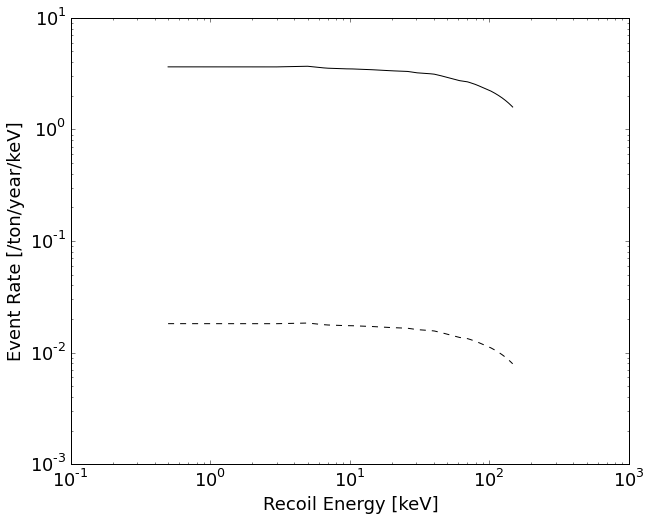

In [91]:
#Generate Flat ER and NR spectra:
S1_bins, mean_S2oS1_flat_n, mean_S2oS1_e, stdev_S2oS1_e = genBands()

# Get S1 and S2 from an exmple PP solar neutrino differential spectrum
Nph, Ne, S1, S2,Calc_Rate_evts_kg_day = dN2NphNe()

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: RuntimeWarning: divide by zero encountered in true_divide
  from IPython.kernel.zmq import kernelapp as app


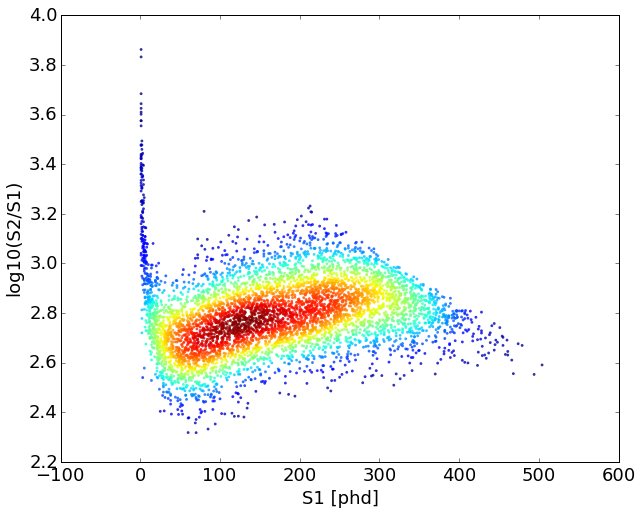

In [96]:
#make a scatter plot
scatterColor(S1,log10(S2/S1))
plt.xlabel('S1 [phd]')
plt.ylabel('log10(S2/S1)')
plt.rcParams.update({'font.size': 18})


/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()


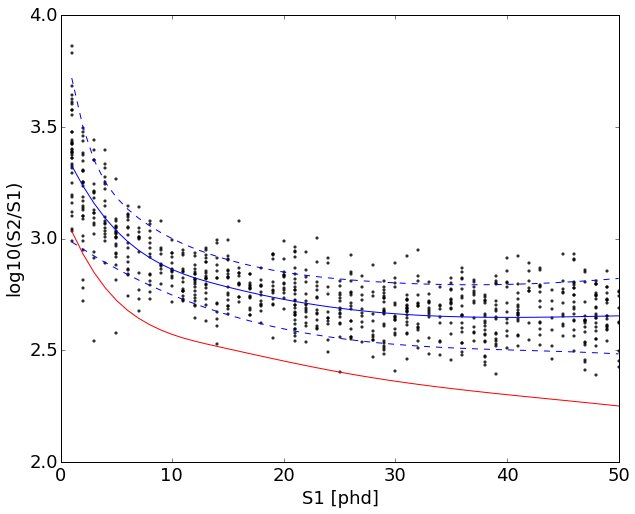

In [99]:
#plot WS region

plt.scatter(S1,log10(S2/S1),c='black',s=5,alpha=0.7)
plt.xlabel('S1 [phd]')
plt.ylabel('log10(S2/S1)')
plt.rcParams.update({'font.size': 18})

#plot NR mean, with a smooth spline
s = ip.UnivariateSpline(S1_bins, log10(mean_S2oS1_flat_n), s=.005)
plot(S1_bins,s(S1_bins),'-r')

#plot ER means, with a smooth spline
s = ip.UnivariateSpline(S1_bins, mean_S2oS1_e, s=.005)
s_ub = ip.UnivariateSpline(S1_bins, mean_S2oS1_e+1.28*stdev_S2oS1_e, s=.005) #1.28 sigma for 10-90% bands
s_lb = ip.UnivariateSpline(S1_bins, mean_S2oS1_e-1.28*stdev_S2oS1_e, s=.005)
plot(S1_bins,s(S1_bins),'-b')
plot(S1_bins,s_ub(S1_bins),'--b')
plot(S1_bins,s_lb(S1_bins),'--b')

xlim([0,50])
savefig('figs/TestPP.pdf')

<h1> Save the data </h1>

In [ ]:
#savetxt('filename',data)